# Proof of concept: Training a structured, recurrent, delayed, long-term plastic SNN

From here on out, we're going to start *very* simple, and build up within this file. No more proliferation of parts.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

import time

In [2]:
dtype = torch.float
device = torch.device("cuda:0") 

In [3]:
time_step = 1e-3
n_steps  = 500

In [4]:
def decayconst_tensor(dt, framework = torch):
    return lambda tau: framework.exp(-dt/tau)

def decayconst(tau):
    return float(np.exp(-time_step/tau))

def sigmoid_project(value, bounds, framework = torch):
    return bounds[0] + (bounds[1]-bounds[0])/(1 + framework.exp(-value))

In [5]:
cortex_params = {
    'batch_size': 4096,
    'n_inputs': 20,
    'n_outputs': 1,
    
    'weight_scale': 0.5, # initial weights are drawn from N(0, weight_scale/sqrt(num))
    
    'tau_mem': 20e-3,                # Membrane time constant
    'tau_mem_out': 20e-3,            # Readout membrane tau
    
    'tau_p': 100e-3,                 # Short-term plasticity recovery
    
    'populations': [
        {'name': 'Exc1',
         'n': 4,
         'sign': 1,
         'p': -0.1,                  # Short-term plasticity coefficient
         'targets': {
             'Exc1': {
                 'density': 0.5,     # Fraction of active synapses, out of all possible in this projection
             },
             'Inh1': {'density': 0.5}
         }
        },
        {'name': 'Inh1',
         'n': 4,
         'sign': -1,
         'p': 0,
         'targets': {
             'Exc1': {'density': 0.5},
             'Inh1': {'density': 0.5}
         }
        },
    ]
}
cortex_params['weight_scale'] = 7*(1.0-decayconst(cortex_params['tau_mem']))

batch_size = cortex_params['batch_size']
n_inputs   = cortex_params['n_inputs']
n_outputs  = cortex_params['n_outputs']

In [6]:
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad

In [7]:
def expand_to_neurons(params, varname, diagonal = False):
    '''
    Expands the population-level variable `varname` from `params` into a neuron-level tensor.
    * If diagonal is False (default), the returned tensor is a size (N) vector.
    * If diagonal is True, the returned tensor is a diagonal matrix of size (N,N).
    '''
    nested = [[p[varname]] * p['n'] for p in params['populations']]
    flat = [i for part in nested for i in part]
    t = torch.tensor(flat, device=device, dtype=dtype)
    return t.diag() if diagonal else t

In [8]:
class Cortex(nn.Module):
    def __init__(self, pars, record_hidden = False):
        super(Cortex, self).__init__()
        self.pars = pars
        self.record_hidden = record_hidden
        self.N = N = sum([p['n'] for p in pars['populations']])
        
        # Network structure
        self.w_signs = expand_to_neurons(pars, 'sign')
        
        
        # Weights
        self.build_connectivity()
        
        w_in = torch.empty((pars['n_inputs'], N),  device=device, dtype=dtype)
        torch.nn.init.normal_(w_in, mean=0.0, std=pars['weight_scale']/np.sqrt(N))
        self.w_in = torch.nn.Parameter(w_in) # LEARN

        w_out = torch.empty((N, pars['n_outputs']), device=device, dtype=dtype)
        torch.nn.init.normal_(w_out, mean=0.0, std=pars['weight_scale']/np.sqrt(pars['n_outputs']))
        self.w_out = torch.nn.Parameter(w_out) # LEARN
        
        
        # Short-term plasticity
        self.p = expand_to_neurons(pars, 'p')
        self.alpha_p = decayconst(pars['tau_p'])
        
        
        # Membrane time constants
        self.alpha_mem = decayconst(pars['tau_mem'])
        self.alpha_mem_out = decayconst(pars['tau_mem_out'])
    
    def build_connectivity(self):
        w = torch.empty((self.N, self.N), device=device, dtype=dtype)
        mask = torch.empty((self.N, self.N), device=device, dtype=dtype)
        zero = torch.zeros(1, device=device, dtype=dtype)
        torch.nn.init.normal_(w, std = self.pars['weight_scale'])
        torch.nn.init.uniform_(mask, -1, 0)
        
        # Build population indices:
        names, ranges = [], []
        k = 0
        for p in self.pars['populations']:
            names.append(p['name'])
            ranges.append(range(k, k+p['n']))
            k += p['n']
        
        # Build projection indices:
        index_pairs, projection_params = [], []
        for p in self.pars['populations']:
            source = ranges[names.index(p['name'])]
            for name, params in p['targets'].items():
                target = ranges[names.index(name)]
                index_pairs.append(np.ix_(source, target))
                projection_params.append(params)
        
        # Build connectivity:
        for idx, p in zip(index_pairs, projection_params):
            indeg = len(idx[0]) * p['density']
            w[idx] /= np.sqrt(indeg)
            mask[idx] += p['density']
        w = torch.where(mask>0, w, zero)
        
        # Register
        self.projection_indices = index_pairs
        self.projection_params = projection_params
        self.w = torch.nn.Parameter(w) # LEARN
                
        
    def forward(self, inputs):
        bs = self.pars['batch_size']
        
        # Compute the input currents
        h1 = torch.einsum("abc,cd->abd", (inputs, self.w_in))

        # Zero-initialise state variables
        mem = torch.zeros((bs,self.N), device=device, dtype=dtype)
        out = torch.zeros((bs,self.N), device=device, dtype=dtype)
        w_p = torch.zeros((bs,self.N), device=device, dtype=dtype)

        # Add Dale's Law signs to recurrent weights
        rec_weights = torch.einsum('e,eo->eo', self.w_signs, torch.abs(self.w))
        
        # Prepare short-term plasticity
        p_depr_mask = self.p < 0

        # Lists to collect states
        spk_rec = []
        if self.record_hidden:
            mem_rec = []
            p_rec = []
            syn_rec = []

        # Compute hidden layer activity
        for t in range(n_steps):
            # Mark spikes
            mthr = mem-1.0
            out = SurrGradSpike.apply(mthr)
            rst = torch.zeros_like(mem)
            rst[mthr > 0] = 1.0
            
            # Synaptic currents
            syn_p = torch.einsum('be,eo->bo', out*(1+w_p), rec_weights)
            w_p = w_p*self.alpha_p + out*self.p*(1 + p_depr_mask*w_p)

            # Record
            spk_rec.append(out)
            if self.record_hidden:
                mem_rec.append(mem)
                p_rec.append(w_p)
                syn_rec.append(syn_p)
            
            # Integrate
            mem = self.alpha_mem*mem +h1[:,t] +syn_p -rst

        # Recordings
        self.spk_rec = torch.stack(spk_rec,dim=1)
        if self.record_hidden:
            self.mem_rec = torch.stack(mem_rec,dim=1)
            self.p_rec = torch.stack(p_rec,dim=1)
            self.syn_rec = torch.stack(syn_rec,dim=1)

        # Readout layer
        h2 = torch.einsum("abc,cd->abd", (self.spk_rec, self.w_out))
        out = torch.zeros((bs,self.pars['n_outputs']), device=device, dtype=dtype)
        out_rec = []
        for t in range(n_steps):
            out = self.alpha_mem_out*out +h2[:,t]
            out_rec.append(out)

        out_rec = torch.stack(out_rec,dim=1)
        return out_rec

### Input
The basic task is one of prediction: I want the network to tell me what the input signal will look like in a short while.

In [9]:
n_freqs = 2
max_freq = 25 # Hz, oscillator frequency
max_rate = 100 # Hz, firing frequency

In [10]:
freqs = torch.abs(torch.randn((1,1,n_freqs,1))) * max_freq
phases = torch.rand((1,1,n_freqs,1))

times = torch.arange(n_steps).reshape(1,-1,1,1) * time_step
raw_rates = torch.sin(2*np.pi*(freqs * times + phases)) * .5 + .5

y_data = (torch.sum(raw_rates, 2)/n_freqs).to(device=device, dtype=dtype).expand(batch_size,n_steps,n_outputs)

samplings = torch.rand((batch_size,1,n_freqs,n_inputs))
rates = torch.sum(raw_rates * samplings, 2)/n_freqs

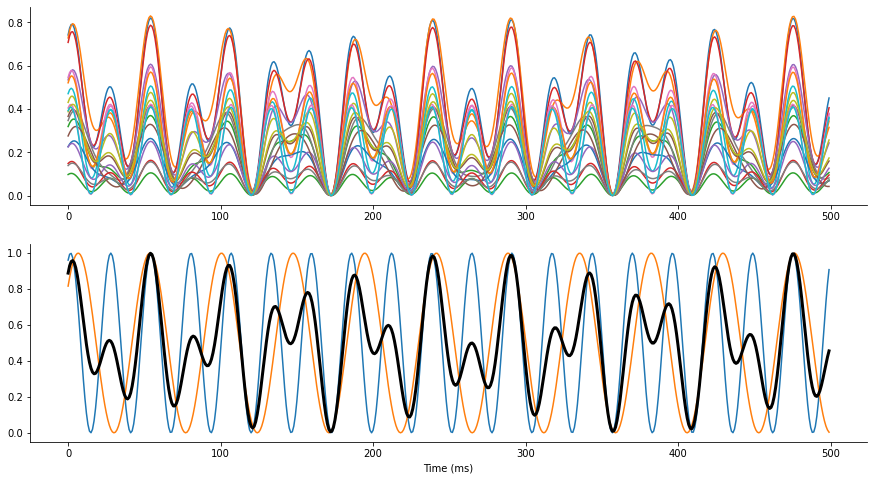

In [11]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.plot(rates[0].numpy())

plt.subplot(212)
plt.plot(raw_rates[0,:,:,0].numpy())
plt.plot(y_data[0].cpu().numpy(), 'black', lw=3)
plt.xlabel('Time (ms)')

sns.despine()

In [12]:
prob = rates.to(device)*time_step*max_rate
mask = torch.rand((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data[mask<prob] = 1.0

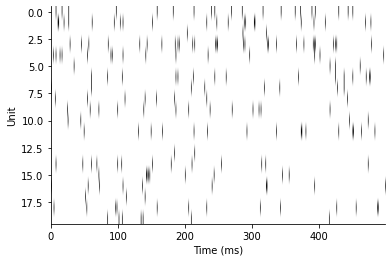

In [13]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Define a helper function to visualise activity:

In [14]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5, ax=None, fig=None):
    if ax is None:
        if fig is None:
            _,ax = plt.subplots(*dim, sharey=True)
        else:
            ax = fig.subplots(*dim, sharey=True)
    ax = ax.flatten()
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        ax[i].plot(dat[i])
        ax[i].axis("off")
    return ax

In [15]:
model = Cortex(cortex_params)
output = model(x_data)

In [16]:
# STP testing
# cortex_params['batch_size'] = 15
# cortex_params['populations'][0]['p'] = 0
# cortex_params['populations'][1]['p'] = 1
# model = Cortex(cortex_params, True)
# with torch.no_grad():
#     model.w_in[model.w_in<0] *= -3
#     model.w[:4,:] = 0
#     model.w[4:,:] = .1
# model(x_data[:15])
# ax = plot_voltage_traces(model.p_rec[:,:100,:], fig=plt.figure(figsize=(20,10)))
# for a in ax:
#     a.plot([0,100],[1,1])
# ax=plot_voltage_traces(model.syn_rec[:,:100,:], fig=plt.figure(figsize=(20,10)));
# for a in ax:
#     a.axis('on')
#     a.grid()

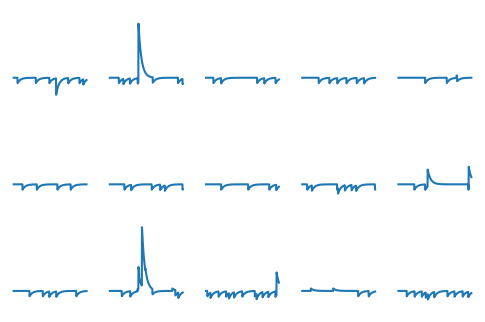

In [17]:
fig=plt.figure(dpi=100)
ax = plot_voltage_traces(output, fig=fig)

In [18]:
loss_fn = torch.nn.MSELoss()
print("Mean squared error: %.3f" % loss_fn(output, y_data))

Mean squared error: 0.324


Let's add a function to inspect the gradients:

In [19]:
from matplotlib.lines import Line2D
def get_grad_plotter(alpha = 0.1, top = 0.02):
    def plot_grads(named_parameters, ax):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad:
                grad = p.grad.abs()
                ave_grads.append(grad.mean())
                max_grads.append(grad.max())
                layers.append(n)
        ax.bar(np.arange(len(max_grads))+.4, max_grads, alpha=alpha, width=.4, color="c")
        ax.bar(np.arange(len(max_grads)), ave_grads, alpha=alpha, width=.4, color="b")
        ax.xaxis.set_ticks(range(0,len(ave_grads), 1))
        ax.xaxis.set_ticklabels(layers, rotation="vertical")
        ax.set_ylim(top=top)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Gradient")
        ax.grid(True)
        ax.legend([Line2D([0], [0], color="c", lw=4),
                   Line2D([0], [0], color="b", lw=4)], ['max-gradient', 'mean-gradient'])
        sns.despine(offset=4)
    return plot_grads

I have no idea whether this will train! Let's try.

Forward, backward, overhead: 0.236 s; 0.681 s; 0.006 s
Forward, backward, overhead: 0.214 s; 0.691 s; 0.048 s
Forward, backward, overhead: 0.219 s; 0.700 s; 0.048 s
Forward, backward, overhead: 0.218 s; 0.692 s; 0.050 s
Forward, backward, overhead: 0.218 s; 0.692 s; 0.048 s
Forward, backward, overhead: 0.216 s; 0.688 s; 0.048 s
Forward, backward, overhead: 0.218 s; 0.687 s; 0.048 s
Forward, backward, overhead: 0.222 s; 0.696 s; 0.048 s
Forward, backward, overhead: 0.226 s; 0.702 s; 0.049 s
Forward, backward, overhead: 0.228 s; 0.705 s; 0.049 s


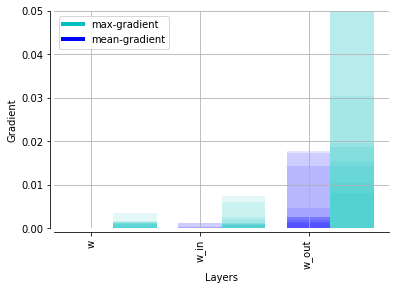

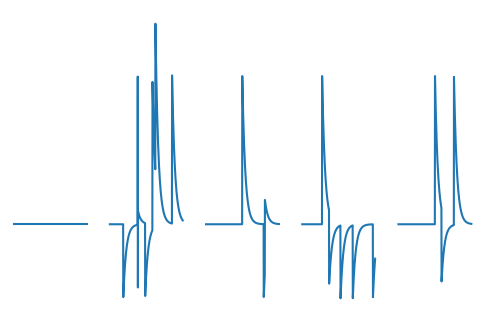

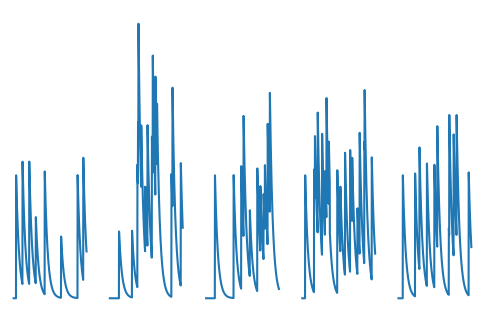

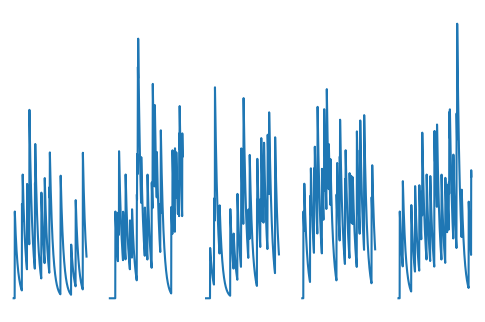

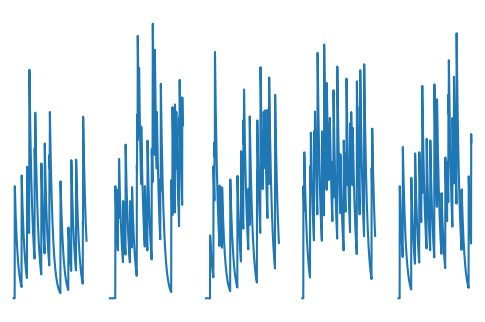

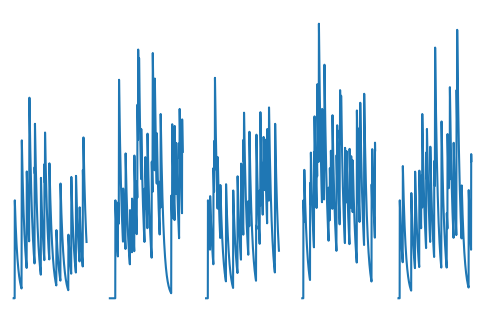

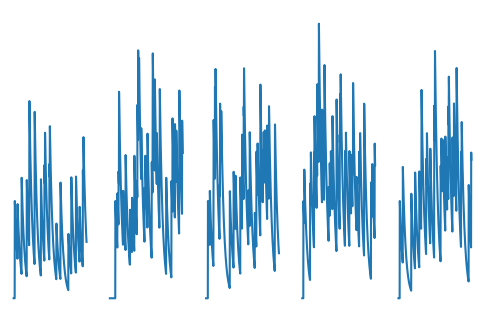

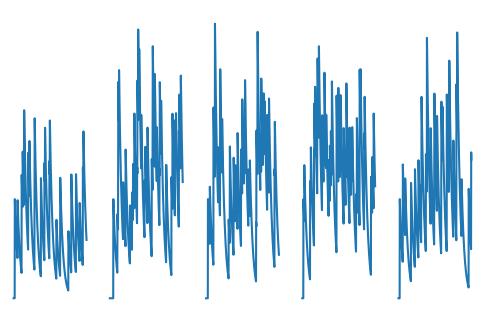

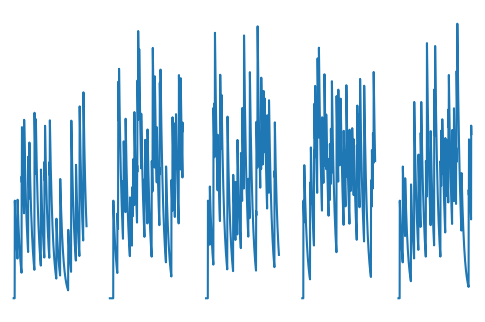

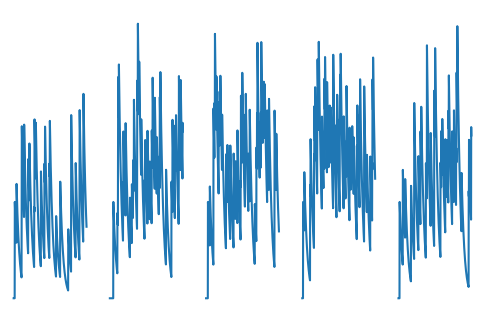

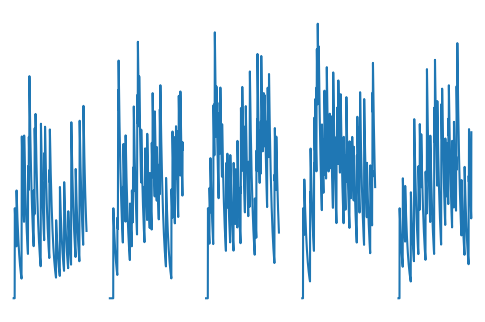

In [20]:
model = Cortex(cortex_params)
with torch.no_grad():
    untrained = model(x_data)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

epochs, reporting_interval = 200, 20
t_forward = t_backward = overhead = 0
tic = time.perf_counter()

ax = plt.figure().subplots()
plot_grad = get_grad_plotter(top=.05)

# The optimization loop
loss_hist = []
for e in range(epochs):
    # run the network and get output
    overhead += time.perf_counter() - tic
    tic = time.perf_counter()
    
    output = model(x_data)
    
    toc = time.perf_counter()
    t_forward += toc-tic
    
    # compute the loss
    loss_val = loss_fn(output, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    tic = time.perf_counter()
    t_backward += tic-toc
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    if e%reporting_interval == 0:
        plot_grad(model.named_parameters(), ax)
        plot_voltage_traces(output, dim=(1,5), fig=plt.figure(dpi=100))
        if e > 0:
            t_forward /= reporting_interval
            t_backward /= reporting_interval
            overhead /= reporting_interval
        print("Forward, backward, overhead: %0.3f s; %0.3f s; %0.3f s" % (t_forward, t_backward, overhead))
        t_forward = t_backward = overhead = 0

0.11318489164113998


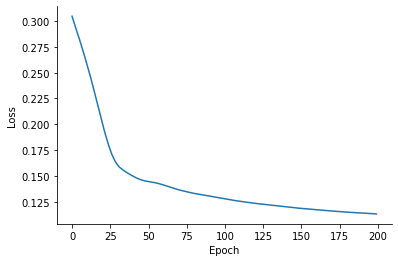

In [21]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
print(loss_hist[-1])

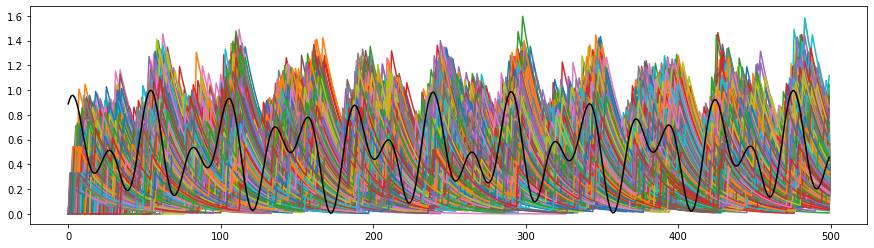

In [22]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().cpu().numpy().T)
plt.plot(y_data[0,:,0].cpu().numpy(), color='black');

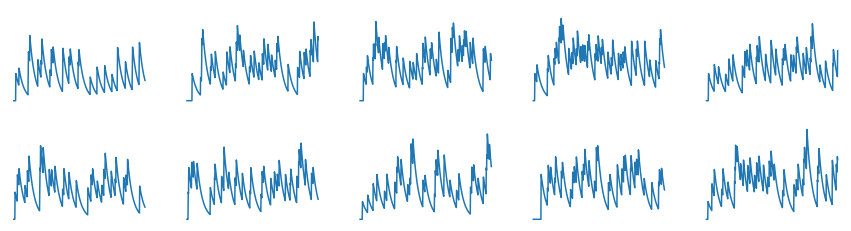

In [23]:
fig=plt.figure(figsize=(15,4))
plot_voltage_traces(output,dim=(2,5),fig=fig);

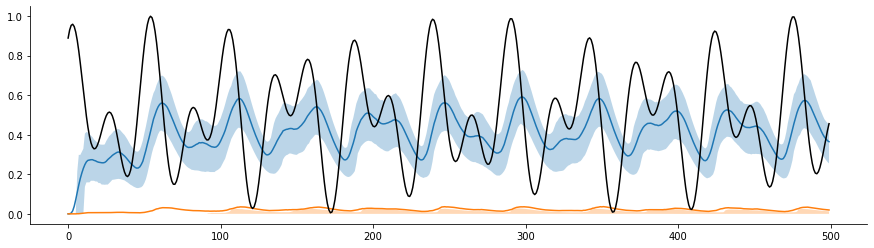

In [24]:
plt.figure(figsize=(15,4))
for out in (output, untrained):
    plt.plot(out[:,:,0].detach().mean(dim=0).cpu().numpy().T)
    lo,hi = [torch.quantile(out[:,:,0].detach(), q, dim=0).cpu().numpy() for q in (.25,.75)]
    plt.fill_between(np.arange(len(lo)), lo, hi, alpha=.3)
plt.plot(y_data[0,:,0].cpu().numpy(), color='black')
sns.despine()

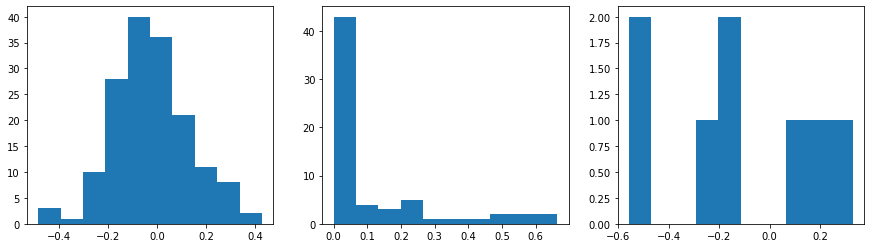

In [25]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.hist(model.w_in.detach().cpu().numpy().flat)
plt.subplot(132)
plt.hist(model.w.detach().abs().cpu().numpy().flat)
plt.subplot(133)
plt.hist(model.w_out.detach().cpu().numpy().flat);

In [26]:
print(model.w_out)

Parameter containing:
tensor([[-0.5568],
        [ 0.1231],
        [-0.5065],
        [ 0.2146],
        [-0.1141],
        [-0.2107],
        [-0.1398],
        [ 0.3290]], device='cuda:0', requires_grad=True)
